In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

In [4]:
class BrainTumorDataProcessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
        self.data = []
        self.labels = []
        
    def load_and_preprocess_images(self, img_size=(224, 224)):
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(self.base_path, 'Training', class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    img = img / 255.0
                    self.data.append(img)
                    self.labels.append(class_idx)
                except Exception as e:
                    print(f"Error processing {img_path}: {str(e)}")
        
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

In [5]:
base_path = '/kaggle/input/brain-tumor-mri-dataset'
processor = BrainTumorDataProcessor(base_path)
processor.load_and_preprocess_images()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


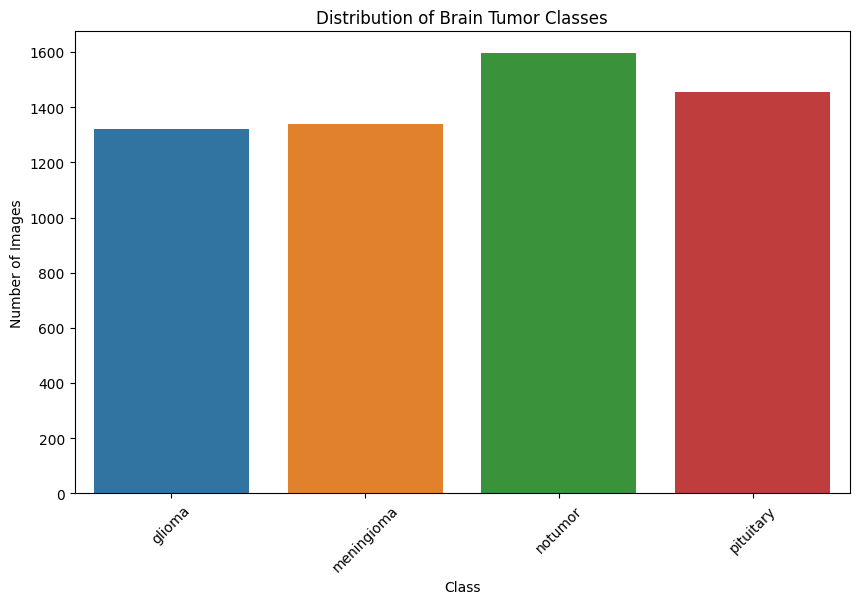

In [6]:
plt.figure(figsize=(10, 6))
unique_labels, counts = np.unique(processor.labels, return_counts=True)
sns.barplot(x=processor.classes, y=counts)
plt.title('Distribution of Brain Tumor Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

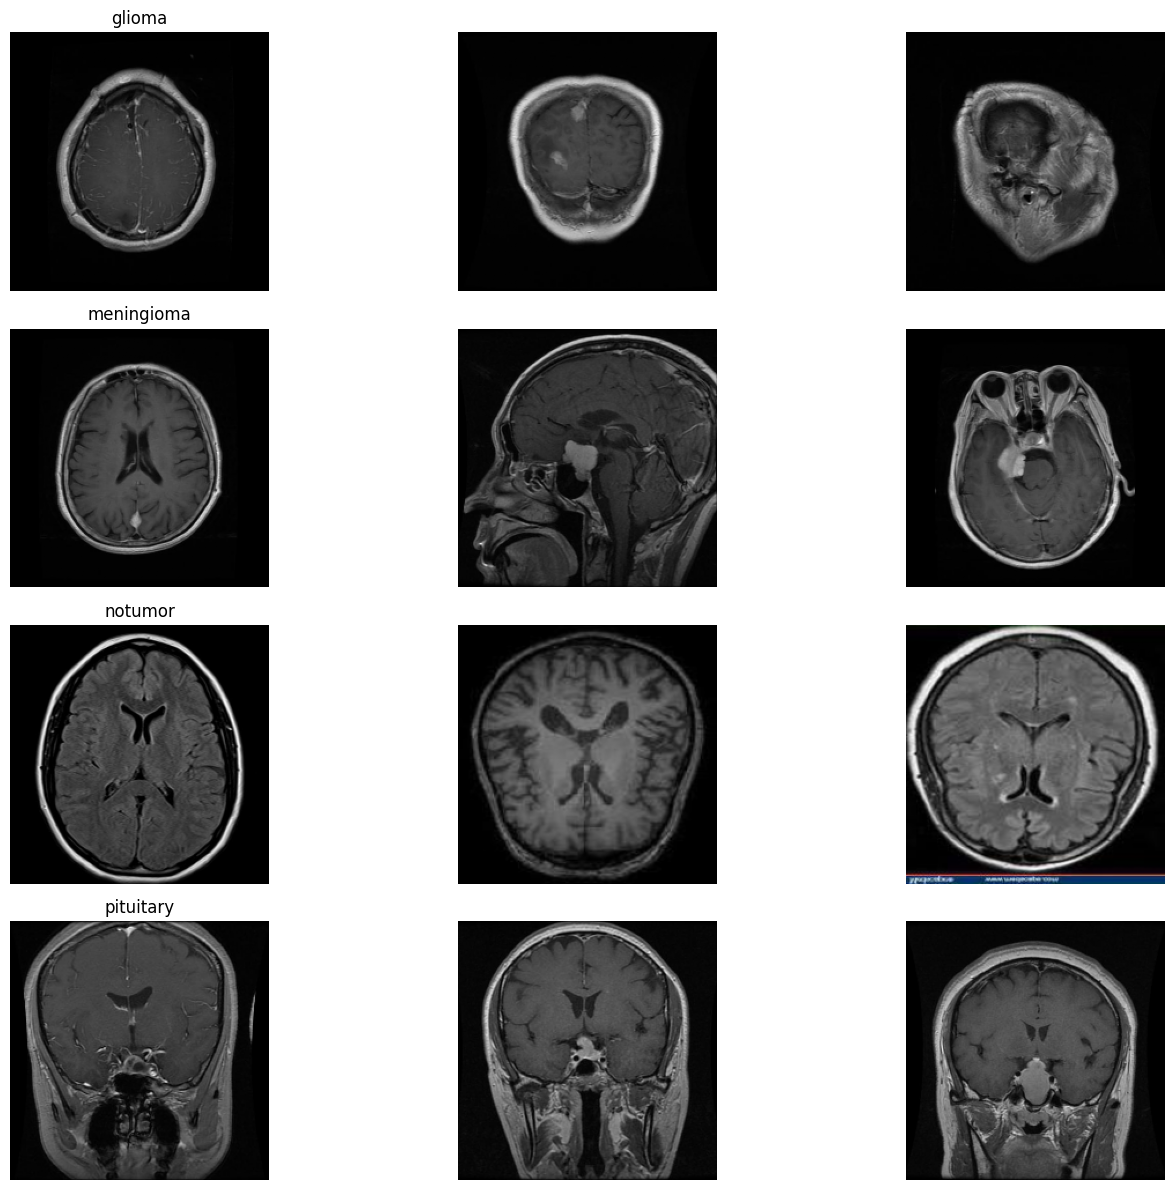

In [7]:
samples_per_class = 3
fig, axes = plt.subplots(len(processor.classes), samples_per_class, figsize=(15, 12))

for i, class_name in enumerate(processor.classes):
    class_indices = np.where(processor.labels == i)[0]
    selected_samples = np.random.choice(class_indices, samples_per_class, replace=False)
    
    for j, idx in enumerate(selected_samples):
        axes[i, j].imshow(processor.data[idx])
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'{class_name}')

plt.tight_layout()
plt.show()

In [8]:
print(f"Dataset Shape: {processor.data.shape}")
print(f"\nPixel Statistics:")
print(f"Mean pixel value: {np.mean(processor.data):.3f}")
print(f"Std pixel value: {np.std(processor.data):.3f}")
print(f"Min pixel value: {np.min(processor.data):.3f}")
print(f"Max pixel value: {np.max(processor.data):.3f}")

Dataset Shape: (5712, 224, 224, 3)

Pixel Statistics:
Mean pixel value: 0.185
Std pixel value: 0.202
Min pixel value: 0.000
Max pixel value: 1.000


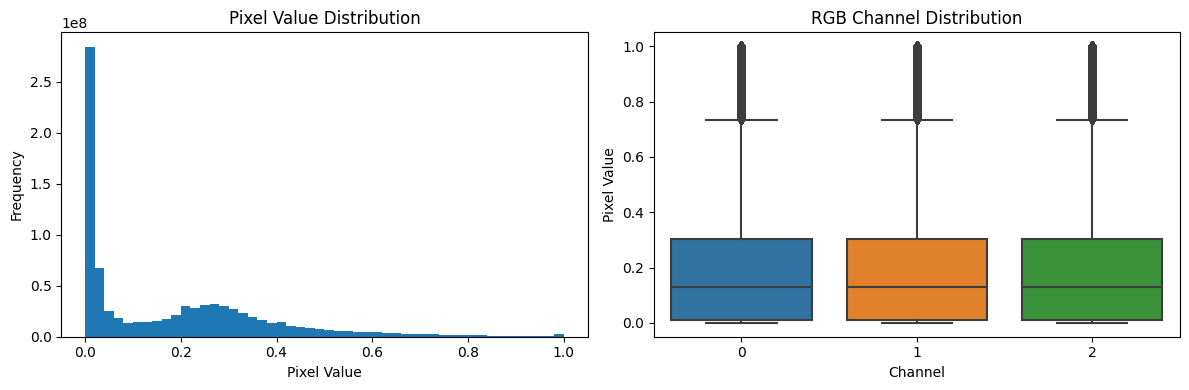

In [9]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(processor.data.ravel(), bins=50)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=processor.data.reshape(-1, processor.data.shape[-1]))
plt.title('RGB Channel Distribution')
plt.xlabel('Channel')
plt.ylabel('Pixel Value')

plt.tight_layout()
plt.show()

In [10]:
X_train, X_val, y_train, y_val = train_test_split(
    processor.data, 
    processor.labels,
    test_size=0.2,
    random_state=42,
    stratify=processor.labels
)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("\nClass distribution in training set:")
print(pd.Series(y_train).value_counts())
print("\nClass distribution in validation set:")
print(pd.Series(y_val).value_counts())

Training set shape: (4569, 224, 224, 3)
Validation set shape: (1143, 224, 224, 3)

Class distribution in training set:
2    1276
3    1165
1    1071
0    1057
Name: count, dtype: int64

Class distribution in validation set:
2    319
3    292
1    268
0    264
Name: count, dtype: int64


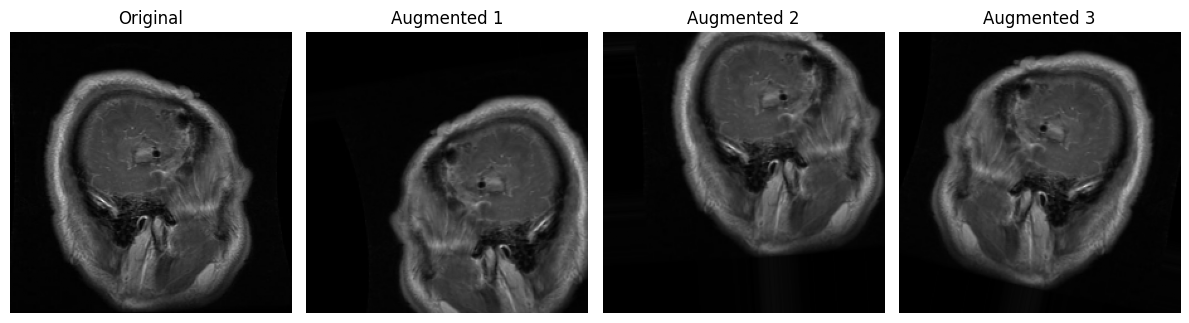

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_image = processor.data[0]
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(sample_image)
plt.title('Original')
plt.axis('off')

for i, augmented in enumerate(datagen.flow(sample_image.reshape(1, 224, 224, 3), batch_size=1), 1):
    plt.subplot(1, 4, i+1)
    plt.imshow(augmented[0])
    plt.title(f'Augmented {i}')
    plt.axis('off')
    if i >= 3:
        break
plt.tight_layout()
plt.show()